# データ前処理

In [51]:
import codecs
import pandas as pd
import warnings
import numpy as np
import re
import json


from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')
train= pd.read_csv('train+.csv', sep=',',engine='c')

test=pd.read_csv('test+.csv', sep=',',engine='c')
price=pd.read_csv('31kouji_chiten_data.csv', sep=',',engine='python',encoding='shift-jis')
train=train.drop(['Unnamed: 0'],axis=1)
test=test.drop(['Unnamed: 0'],axis=1)
train_tmp = train.copy()
test_tmp = test.copy()
# train_tmp = train_tmp.drop("賃料", axis=1)
df = pd.concat([train_tmp, test_tmp])
df=df.reset_index(drop=True)
df=df.rename(columns={'所在地':'address','アクセス':'access','間取り':'space','面積':'width','放送・通信':'information','築年数':'years','方角':'direction', '所在階':'bfloor','バス・トイレ':'bath','キッチン':'kitchen','室内設備':'service','駐車場':'parking','周辺環境':'enviroment','建物構造':'architect','契約期間':'period','lat':'lat','lng':'lng',"賃料":"value"})
# price=price.rename(columns={'緯度':'lat','経度':'lng','市区町村名':'area','住居表示':'address','地積':'width','利用状況表示':'usage','建物構造':'architect','階層（地上）':'height','前面道路区分':'road','前面道路の方位区分':'direction','前面道路の幅員':'width','周辺の土地の利用の現況':'situation','駅名':'station','駅距離':'dis','用途区分':'application',
#                             '防火区分':'fire','Ｈ３０価格':'price'})
# price.address=price.address.map(lambda x:x.split("　")[1])
# price["address0"]=price.address.map(lambda x:x.split("区")[0])
# price["address1"]=price.address.map(lambda x:x.split("区")[1])
price["address"]=price.address.map(lambda x:re.split("１|２|３|４|５|６|７|８|９|1|2|3|4|5|6|7|8|9|一丁目|二丁目|三丁目|四丁目|五丁目|六丁目|七丁目|八丁目",x)[0])


In [52]:
def filter_dis(x):
    return np.sqrt((x.lat-35.681236)**2.0+(x.lng-139.767125)**2.0)

dis=(df.lat-35.681236)**2+(df.lng-139.767125)**2.0

def filter_conv(x):
    try :
        if "コンビニ" in x:
            return 1
        else :
            return 0
    except TypeError:
        return 0
conv=df.enviroment.map(filter_conv)

def filter_period(x):
    try :
        if "定期借家" in x:
            return 1
        else :
            return 0
    except TypeError:
        return 0
    

rp=df.period.map(filter_period)

def filter_period2(x):
    try :
        if "定期借家" in x:
            return "定期借家"
        else :
            return x
    except TypeError:
        return x
    
period=df.period.map(filter_period2)
#アクセス時間の前処理
access=df.access.str.split("\t\t",expand=True)

access.columns=['access0','access1','access2','access3']
access

def filter_eki(x):
    try :
        return x.split("\t")[1]
    except AttributeError:
        return " "
    except IndexError:
        return " "
def stationdelete(x):
    try:
        return x.replace("駅"," ")
    except AttributeError:
        return " "
kari0=access.applymap(filter_eki).access0
kari1=access.applymap(filter_eki).access1
kari2=access.applymap(filter_eki).access2
kari3=access.applymap(filter_eki).access3
kari=(kari0+kari1+kari2+kari3).map(stationdelete)

docs = np.array(kari)
count = CountVectorizer()
bags = count.fit_transform(docs)

print(bags.toarray())
# [[1 1 1 0]
#  [0 1 1 1]]

ekifeatures = count.get_feature_names()
# print(features)

nearstation=pd.DataFrame(bags.toarray(),columns=ekifeatures)

def srashdelete(x):
    try:
        return x.replace('／','')
    except AttributeError:
        return " "
se=df.service.map(srashdelete)
def filter_se(x):
    try :
        j=''
        for i in x:
            j+=i+' '
        return j
    except AttributeError:
        return " "
    except IndexError:
        return " "
se=se.str.split("\t").map(filter_se)

docs = np.array(se)
count = CountVectorizer()
bags = count.fit_transform(docs)

print(bags.toarray())
# [[1 1 1 0]
#  [0 1 1 1]]

sefeatures = count.get_feature_names()
# print(features)

se=pd.DataFrame(bags.toarray(),columns=sefeatures)

def filter_ts(x):
    try:
        return int(x.count("\t"))
    except IndexError:
        return 9
    except TypeError:
        return 9
    except AttributeError:
        return 9
sn=df.service.map(filter_ts)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [53]:
df

,id,lat,lng,access,kitchen,bath,enviroment,period,service,architect,address,bfloor,information,direction,years,value,space,width,parking
0,1,35.748456,139.728800,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,2年間,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,RC（鉄筋コンクリート）,東京都北区滝野川３丁目,1階／12階建,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,南東,9年9ヶ月,75000.0,1K,20.01m2,駐輪場\t空有
1,2,35.662885,139.778627,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,ガスコンロ／\tシステムキッチン\t／\t給湯,専用トイレ／\tシャワー／\t温水洗浄便座,【スーパー】 1283m,2年間,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,鉄骨造,東京都中央区月島３丁目,5階／10階建,インターネット対応,NaN,44年10ヶ月,76000.0,1R,16.5m2,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無
2,3,35.675153,139.666255,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,2年間,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,RC（鉄筋コンクリート）,東京都渋谷区笹塚２丁目,12階／15階建,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,南,8年6ヶ月,110000.0,1K,22.05m2,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m"
3,4,35.700170,139.648465,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,ガスコンロ／\t給湯,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,2年間\t※この物件は\t定期借家\tです。,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,RC（鉄筋コンクリート）,東京都杉並区高円寺南２丁目23-2,3階／4階建,インターネット対応／\t光ファイバー,南,29年4ヶ月,150000.0,2LDK,60.48m2,駐車場\t無\t駐輪場\t無\tバイク置き場\t無
4,5,35.766431,139.872321,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,給湯／\t独立キッチン,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,2年間,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,木造,東京都葛飾区金町３丁目7-2,1階／2階建,NaN,南,31年7ヶ月,74000.0,2DK,39.66m2,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無"
5,6,35.733822,139.795246,常磐線快速\t南千住駅\t徒歩2分\t\t都電荒川線\t三ノ輪橋駅\t徒歩10分\t\t日比...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,【スーパー】 251m\t【コンビニ】 376m,2年間,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,RC（鉄筋コンクリート）,東京都荒川区南千住５丁目,6階／12階建,インターネット対応／\t光ファイバー,東,7年6ヶ月,160000.0,2LDK,50.8m2,"駐輪場\t空有\t駐車場\t近隣\t27,000円(税込)\t距離150m\tバイク置き場\t無"
6,7,35.752992,139.587849,西武池袋線\t大泉学園駅\t徒歩4分\t\t西武池袋線\t保谷駅\t徒歩25分\t\t東武東...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,【スーパー】 812m\t【コンビニ】 149m\t【コンビニ】 942m\t【スーパー】 ...,2年間,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,RC（鉄筋コンクリート）,東京都練馬区東大泉３丁目,6階／8階建,インターネット対応／\t光ファイバー／\tCATV／\tBSアンテナ,南,10年5ヶ月,78500.0,1K,23.82m2,"駐輪場\t空有\t駐車場\t近隣\t16,000円(税込)\t距離200m\tバイク置き場\t無"
7,8,35.625996,139.686671,東急東横線\t学芸大学駅\t徒歩7分\t\t東急東横線\t都立大学駅\t徒歩16分\t\t東...,ガスコンロ／\tコンロ2口／\tシステムキッチン,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄...,【スーパー】 334m\t【スーパー】 562m\t【スーパー】 694m\t【コンビニ】 ...,2年間,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,RC（鉄筋コンクリート）,東京都目黒区鷹番１丁目,1階／6階建,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,NaN,14年4ヶ月,115000.0,1K,32.32m2,NaN
8,9,35.719499,139.755944,南北線\t東大前駅\t徒歩3分\t\t都営三田線\t白山(東京都)駅\t徒歩10分\t\t千...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t洗面台独立,NaN,2年間,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,SRC（鉄骨鉄筋コンクリート）,東京都文京区向丘１丁目,4階／9階建,NaN,北西,44年8ヶ月,184327.0,2DK,65.59m2,駐車場\t無
9,10,35.751231,139.718584,埼京線\t板橋駅\t徒歩8分\t\t都営三田線\t新板橋駅\t徒歩4分\t\t東武東上線\t...,ガスコンロ／\tコンロ2口／\t給湯,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立,NaN,2年間,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,鉄骨造,東京都板橋区板橋４丁目,2階／3階建,光ファイバー／\tCATV,南東,38年9ヶ月,76000.0,1DK,30.3m2,駐車場\t無


In [54]:
def srashdelete(x):
    try:
        return x.replace('／','')
    except AttributeError:
        return " "
ba=df.bath.map(srashdelete)
def filter_ba(x):
    try :
        j=''
        for i in x:
            j+=i+' '
        return j
    except AttributeError:
        return " "
    except IndexError:
        return " "
ba=ba.str.split("\t").map(filter_ba)

docs = np.array(ba)
count = CountVectorizer()
bags = count.fit_transform(docs)

print(bags.toarray())
# [[1 1 1 0]
#  [0 1 1 1]]

bafeatures = count.get_feature_names()
# print(features)

ba=pd.DataFrame(bags.toarray(),columns=bafeatures)

[[1 0 1 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 [1 0 1 ... 1 1 0]
 ...
 [1 0 1 ... 1 0 1]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 0 0]]


In [55]:
access=access.applymap(lambda x:x.split("歩") if x is not None else None)
def filter_func1(x):
    try:
        return int(x[1].replace("分",""))
    except IndexError:
        return None
    except TypeError:
        return None
    except ValueError:
        return None
access=access.applymap(filter_func1)

accessmiss=access[access.access0.isnull()].index
access.access0.ix[accessmiss]=[15,1,15,15,7,9,10,11,8,10,13,8,8]
access=access.fillna(method='ffill',axis='columns')
access=access.fillna(method='bfill',axis='columns')
access[access.index==9845]=1
access[access.index==56577]=13

address=df.address
address=address.map(lambda x :x.replace("東京都",""))
address1=address.map(lambda x:x.split("区")[0])
address2=address.map(lambda x:x.split("区")[1])
address2=address2.map(lambda x:re.split("１|２|３|４|５|６|７|８|９|1|2|3|4|5|6|7|8|9|一丁目|二丁目|三丁目|四丁目|五丁目|六丁目|七丁目|八丁目",x)[0] )
df["address2"]=address2

townlist=list(df.groupby("address2").value.mean().sort_values().index)
towndic={}
for i, feat in enumerate(townlist):
    towndic[feat]=i
towndic
ntown=df.address2.map(towndic)
ntown[ntown.isnull()]=280
ntown=834-ntown
ntownlist=list(ntown[ntown.isnull()].index)

#築年数の前処理
years=df.years
years.map(lambda x:str(x.split("年")[0]))
def filter_func2(x):
    kari=x.split("年")[0]
    if kari=="新築":
        return 0
    else :
        return int(kari)
years=years.map(filter_func2)

#間取りの前処理
import re
df["room"]=0
df["R"]=0
df["L"]=0
df["DK"]=0
df["LDK"]=0
df["D"]=0
df["K"]=0
df["S"]=0
df.room=df.space.apply(lambda x: int(re.split("L|D|K|S|R",x)[0]))
df.R=df.space.apply(lambda x: 1 if "R" in x else 0)
df.L=df.space.apply(lambda x: 1 if "L" in x else 0)
df.DK=df.space.apply(lambda x: 1 if "DK" in x else 0)
df.LDK=df.space.apply(lambda x: 1 if "LDK" in x else 0)
df.D=df.space.apply(lambda x: 1 if "D" in x else 0)
df.K=df.space.apply(lambda x: 1 if "K" in x else 0)
df.S=df.space.apply(lambda x: 1 if "S" in x else 0)

room=df.space.apply(lambda x: re.split("L|D|K|S|R",x)[0])
R=df.space.apply(lambda x: 1 if "R" in x else 0)
L=df.space.apply(lambda x: 1 if "L" in x else 0)
DK=df.space.apply(lambda x: 1 if "DK" in x else 0)
LDK=df.space.apply(lambda x: 1 if "LDK" in x else 0)
D=df.space.apply(lambda x: 1 if "D" in x else 0)
K=df.space.apply(lambda x: 1 if "K" in x else 0)
S=df.space.apply(lambda x: 1 if "S" in x else 0)
room=room.apply(lambda x:int(x))

bfloor=df.bfloor
import numpy as np
bfloor1=bfloor.map(lambda x: x.split("／")[0] if type(x) is str else "2階")
def floor_func(x):
    try :
        return x.split("／")[1]
    except IndexError:
        return x.split("／")[0]
    except AttributeError:
        return "2階"
bfloor2=bfloor.map(floor_func)

bfloor1=bfloor1.map(lambda x:x.replace("地下","-"))
bfloor2=bfloor2.map(lambda x:x.replace("地下","-"))
bfloor1=bfloor1.map(lambda x:x.split("階")[0])
bfloor2=bfloor2.map(lambda x:x.split("階")[0])
bfloor = pd.concat([bfloor1, bfloor2], axis=1)

bfloor.columns=["bfloor","height"]
#前処理
bfloor.bfloor[bfloor.bfloor==""]=None
bfloor=bfloor.fillna(method='ffill',axis='columns')
bfloor=bfloor.fillna(method='bfill',axis='columns')
bfloor=bfloor.applymap(lambda x:int(x))
bfloor1=bfloor.bfloor
bfloor2=bfloor.height
bfloor3=bfloor2-bfloor1

#面積の前処理
width=df.width
width=width.map(lambda x:float(x.replace("m2","")))

architect=df.architect
architect=architect.map(lambda x: 0 if "木造" in x else 1)

direction=df.direction
direction=direction.fillna(method='ffill')
# direction=direction.map(lambda x:1if "南" in x else 0)

def filter_pa(x):
    try:
        if '空有' in x:
            return 1
        else:
            return 0
    except TypeError:
        return 0
#前処理

pa=df.parking.map(filter_pa)

new=df.years.map(lambda x :1if x=="新築" else 0)
one=bfloor1.map(lambda x:1 if x==1 else 0)
bid=df.id
lat=df.lat
lng=df.lng

In [56]:
block={"ブロック":1,"その他":4,"鉄骨造":7,"木造":8,"ALC（軽量気泡コンクリート）":5,"RC（鉄筋コンクリート）":10,"HPC（プレキャスト・コンクリート（重量鉄骨））":2,"PC（プレキャスト・コンクリート（鉄筋コンクリート））":3,"鉄筋ブロック":0,"軽量鉄骨":6,"SRC（鉄骨鉄筋コンクリート）":9}
architect=df.architect.map(block)
dis=(lat-35.651816)**2+(lng-139.741531)**2
dis=(dis)*1000+1
access.access0=access.access0.max()-access.access0
landprice=address2.map(price.groupby("address").mean().price.map(int))
dropland=landprice[landprice.isnull()].index
# landprice.ix[dropland]
landprice.ix[dropland]=address1.ix[dropland].map(price.groupby("address").mean().price.map(int))
landprice=landprice*width
kari1[kari1==' ']=kari0.ix[kari1[kari1==' '].index]
stalist=list(pd.concat([df,kari0],axis=1).groupby("access0").mean().value.sort_values().index)
stadic={}
for i,station in enumerate(stalist):
    stadic[station]=i
stan0=kari0.map(stadic)
stalist=list(pd.concat([df,kari1],axis=1).groupby("access1").mean().value.sort_values().index)
stadic={}
for i,station in enumerate(stalist):
    stadic[station]=i
stan1=kari1.map(stadic)

In [57]:
# df.ix[[10876,20674,31364,41186,44494]].drop(["R","L","D","K","LDK","D","K","S","room","DK"],axis=1)

In [58]:
# df.ix[[20427,20926,20231,7491,5775]].drop(["R","L","D","K","LDK","D","K","S","room","DK"],axis=1)

In [59]:
addic={"葛飾":0, "足立":1,"江戸川":2,"板橋":3,"練馬":4,"杉並":5,"北":6,"中野":7,"大田":8,"豊島":9,"世田谷":10,"荒川":11,"墨田":12,"品川":13,"新宿":14,"文京":15,"江東":16,"台東":17,"目黒":18,"渋谷":19,"千代田":20,"中央":21,"港":22}
ad=address1.map(addic)

In [60]:
df_tofile=pd.concat([bid,access.access0,address1,address2,years,lat,lng,room,L,D,S,bfloor1,bfloor2,bfloor3,width,architect,direction,pa,rp,sn,nearstation,se,ba,dis,ad,kari0,ntown,period,landprice,stan0,stan1], axis=1)
# df_tofile=pd.concat([bid,access.access0,address1,address2,years,lat,lng,room,L,D,S,bfloor1,bfloor2,bfloor3,width,architect,direction,pa,rp,sn,nearstation,se,dis,ad], axis=1)
# df_tofile=pd.concat([bid,access.access0,address1,years,lat,lng,room,L,D,S,bfloor1,bfloor2,bfloor3,width,architect,direction,ih,wm,pa,air,rp,flooring,bal,loft,sn,sharetoilet,separatebath], axis=1)
df_tofile=pd.merge(df_tofile, train[["id","賃料"]], how='outer', on='id')

df_tofile.columns=["id","access","address","town","years","lat","lng","room","L","D","S","bfloor","height","floordif","width","architect","direction","pa","rp","sn"]+list(nearstation.columns)+list(se.columns)+list(ba.columns)+["dis","ad","kari0","ntown","period","landprice","stan0","stan1"]+["value"]
# df_tofile.columns=["id","access","address","town","years","lat","lng","room","L","D","S","bfloor","height","floordif","width","architect","direction","pa","rp","sn"]+list(nearstation.columns)+list(se.columns)+["dis","ad"]+["value"]
# df_tofile.columns=["id","access","address","years","lat","lng","room","L","D","S","bfloor","height","floordif","width","architect","direction","ih","wm","pa","air","rp","flooring","bal","loft","sn","sharetoilet","separatebath"]+["value"]
# df_tofile=df_tofile.drop(["L","D","ih"],axis=1)
df_tofile=df_tofile.drop("id",axis=1)
# df_tofile=df_tofile.drop(df_tofile.index[30539])
df_tofile=df_tofile.drop(df_tofile.index[20926])
df_tofile=df_tofile.drop(df_tofile.index[20427])
df_tofile=df_tofile.drop(df_tofile.index[20231])
df_tofile=df_tofile.drop(df_tofile.index[7491])
df_tofile=df_tofile.drop(df_tofile.index[5775])
# df_tofile=df_tofile.drop(df_tofile.index[5093])
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [61]:
# #数値型の特徴量だけ
# df_num = df_tofile.select_dtypes(include="number")
# df_num = df_num
 
# #相関行列を作成
# corrmat = df_num.corr()
 
# #相関行列のpriceの列と、特徴量の名前をデータフレームに
# corrPrice = pd.DataFrame({"features":df_num.columns,"corr_Price":corrmat["value"]},index=None)
# corrPrice = corrPrice.reset_index(drop=True)
# corrPrice.style.background_gradient()

In [62]:
# df1=df_tofile[["access","ad","years","lat","lng","L","D","height","width","エレベーター","architect","dis","ntown","bfloor","rp","value"]] #15305
# df1=df_tofile[["access","ad","years","lat","lng","L","D","height","width","エレベーター","architect","dis","ntown","bfloor","landprice","stan0","value"]] #14925
df1=df_tofile[["access","ad","years","lat","lng","L","D","height","width","エレベーター","architect","dis","ntown","bfloor","landprice","stan0","value"]] #14925

In [63]:
df1.isnull().sum()

access           0
ad               0
years            0
lat              0
lng              0
L                0
D                0
height           0
width            0
エレベーター           0
architect        0
dis              0
ntown            0
bfloor           0
landprice     1981
stan0            0
value        31262
dtype: int64

In [64]:
from sklearn.model_selection import train_test_split, GridSearchCV

train = df1.dropna()
test=df1[df1.isnull().any(axis=1)]
testX=test.dropna()
X = pd.get_dummies(train)

#　目的変数に家賃単価を代入する
y = train.value
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [65]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib
matplotlib.matplotlib_fname()
import matplotlib as mpl
mpl.get_configdir()
import matplotlib as mpl
mpl.font_manager._rebuild() 
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'IPAexGothic'


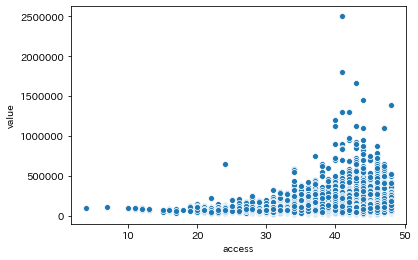

In [66]:
sns.scatterplot(x="access",y="value",data=train)

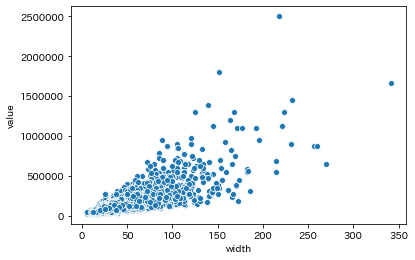

In [67]:
sns.scatterplot(x="width",y="value",data=train)

In [68]:
# df1[(df1.stan1<200)&(df1.value>600000)].index

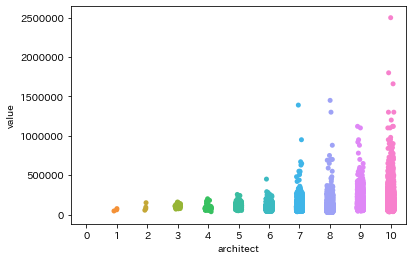

In [69]:
sns.stripplot(x="architect",y="value",data=df1)

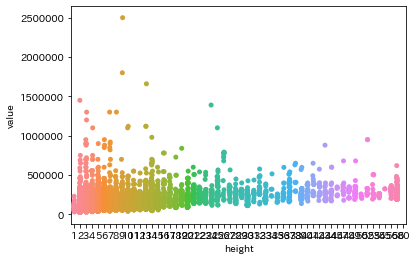

In [70]:
sns.stripplot(x="height",y="value",data=df1)

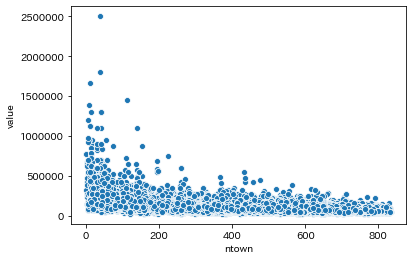

In [71]:
sns.scatterplot(x="ntown",y="value",data=df1)

In [72]:
# townlist=list(train.groupby("town").value.mean().sort_values().index)
# towndic={}
# for i, feat in enumerate(townlist):
#     towndic[feat]=i
# towndic
# ntown=df1.town.map(towndic)
# ntown[ntown.isnull()]=280
# ntown=834-ntown
# ntownlist=list(ntown[ntown.isnull()].index)


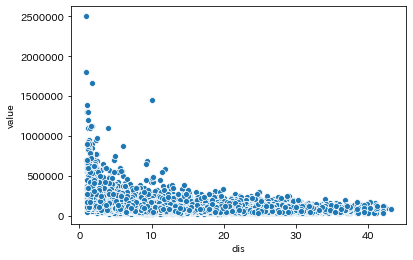

In [73]:
sns.scatterplot(x="dis",y="value",data=train)


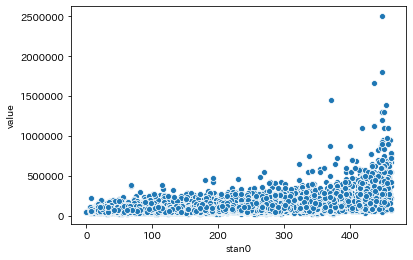

In [74]:
sns.scatterplot(x="stan0",y="value",data=train)

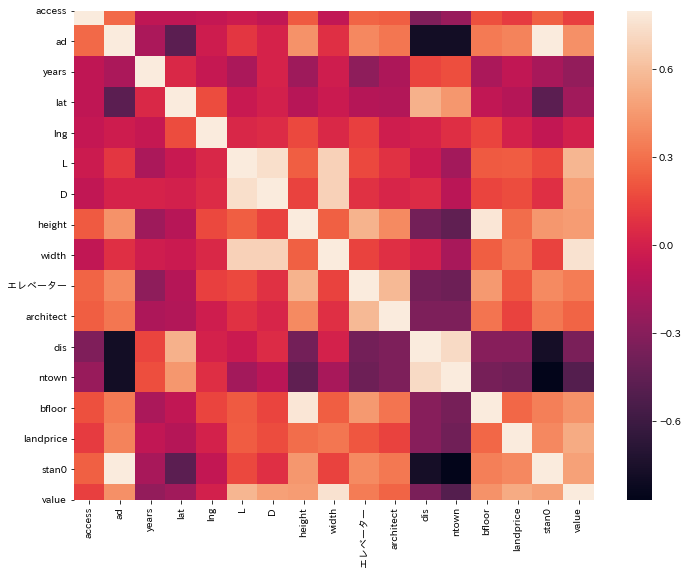

In [75]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

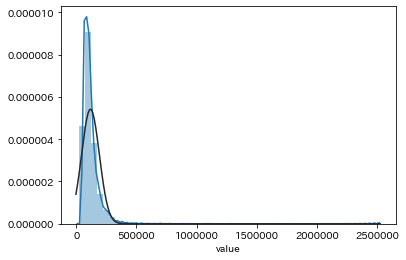

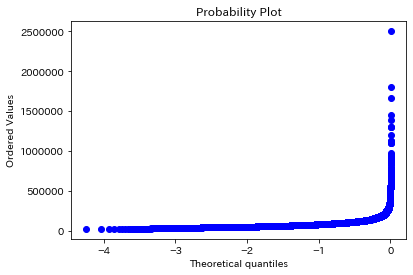

In [76]:
from scipy import stats
from scipy.stats import norm
sns.distplot(df1["value"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["value"], plot=plt)

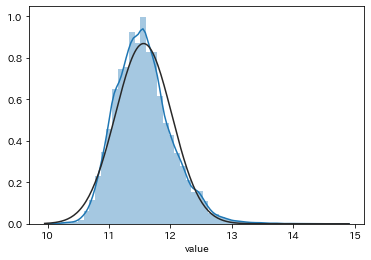

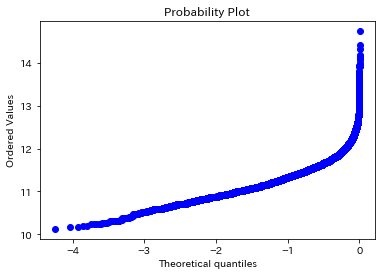

In [77]:
df1["value"]=np.log(df1.value)
# df1["value"]=stats.boxcox( df1.value, lmbda =-1 )
#transformed histogram and normal probability plot
sns.distplot(df1.value.dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1.value, plot=plt)

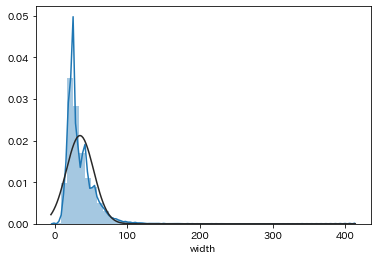

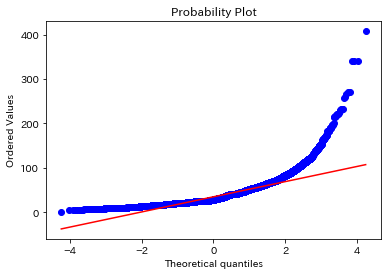

In [78]:
sns.distplot(df1["width"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["width"], plot=plt)

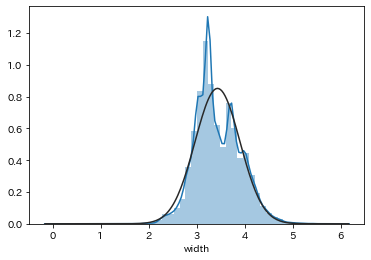

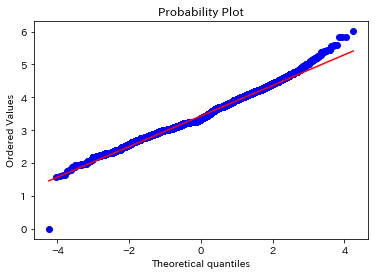

In [79]:
df1["width"]=np.log(df1.width)
#transformed histogram and normal probability plot
sns.distplot(df1.width.dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1.width, plot=plt)

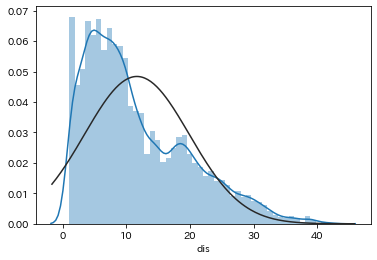

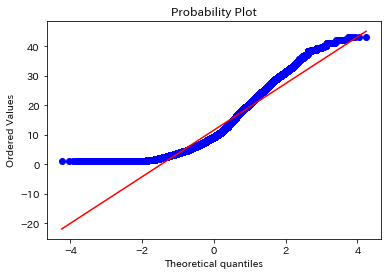

In [80]:
sns.distplot(df1["dis"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["dis"], plot=plt)

In [81]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy import stats

# fig = plt.figure(figsize=(6.0, 6.0))
# aaa=pd.DataFrame()
# list_lambda = [-2, -1, -0.5, 0, 0.5, 1, 2]
# for i, i_lambda in enumerate(list_lambda):
#     aaa[ 'val_'+str(i) ] = stats.boxcox( df1.dis, lmbda = i_lambda )
#     fig.add_subplot(4, 2, i+1).hist(aaa['val_'+str(i)], bins=20, color='r', alpha=0.5, density=True)
#     plt.title("lambda="+str(list_lambda[i]))
#     plt.xlabel('val')
#     plt.ylabel('density')

# aaa[ 'val_auto' ], best_lambda = stats.boxcox( df1.dis)
# fig.add_subplot(4, 2, 8).hist(aaa['val_auto'], bins=20, color='r', alpha=0.5, density=True)
# plt.title("lambda="+str(round(best_lambda, 2)))
# plt.xlabel('val')
# plt.ylabel('density')

# fig.tight_layout()
# fig.show()
# plt.show()

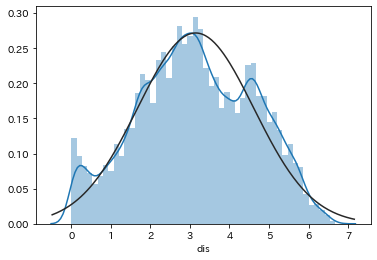

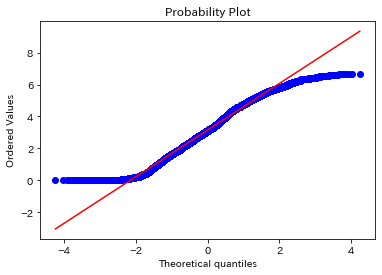

In [82]:
df1["dis"]=stats.boxcox( df1.dis, lmbda =0.28 )
#transformed histogram and normal probability plot
sns.distplot(df1.dis.dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1.dis, plot=plt)

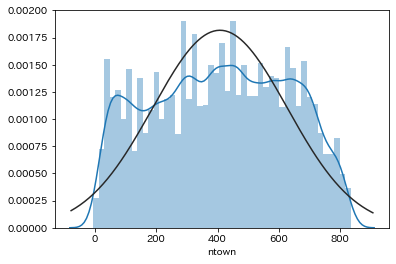

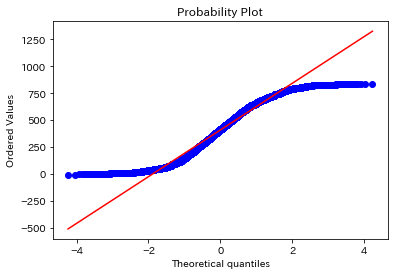

In [83]:
sns.distplot(df1["ntown"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["ntown"], plot=plt)

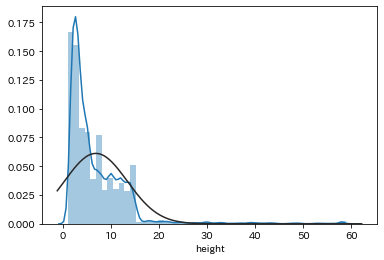

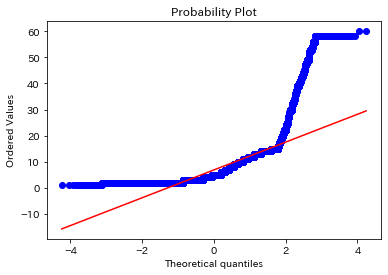

In [84]:
from scipy import stats
from scipy.stats import norm
sns.distplot(df1["height"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["height"], plot=plt)

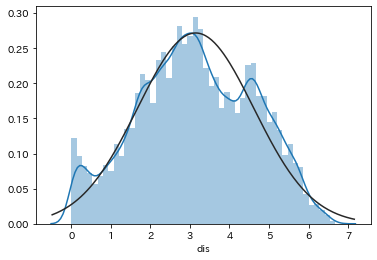

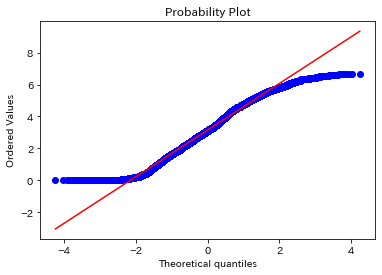

In [85]:
df1["height"]=stats.boxcox( df1.height, lmbda =0.28 )
#transformed histogram and normal probability plot
sns.distplot(df1.dis.dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1.dis, plot=plt)

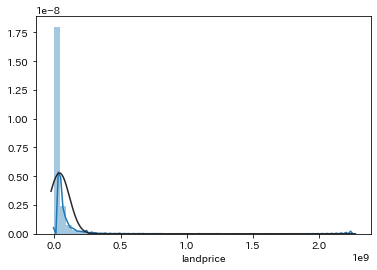

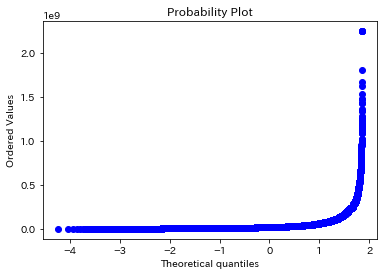

In [86]:
sns.distplot(df1["landprice"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["landprice"], plot=plt)

In [87]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy import stats

# fig = plt.figure(figsize=(6.0, 6.0))
# aaa=pd.DataFrame()
# list_lambda = [-2, -1, -0.5, 0, 0.5, 1, 2]
# for i, i_lambda in enumerate(list_lambda):
#     aaa[ 'val_'+str(i) ] = stats.boxcox( df1.landprice, lmbda = i_lambda )
#     fig.add_subplot(4, 2, i+1).hist(aaa['val_'+str(i)], bins=20, color='r', alpha=0.5, density=True)
#     plt.title("lambda="+str(list_lambda[i]))
#     plt.xlabel('val')
#     plt.ylabel('density')

# aaa[ 'val_auto' ], best_lambda = stats.boxcox( df1.landprice)
# fig.add_subplot(4, 2, 8).hist(aaa['val_auto'], bins=20, color='r', alpha=0.5, density=True)
# plt.title("lambda="+str(round(best_lambda, 2)))
# plt.xlabel('val')
# plt.ylabel('density')

# fig.tight_layout()
# fig.show()
# plt.show()

In [88]:
# from scipy import stats
# from scipy.stats import norm
# sns.distplot(df1["stan0"].dropna(), fit=norm);
# fig = plt.figure()
# res = stats.probplot(df1["stan0"], plot=plt)

In [89]:
from sklearn.model_selection import train_test_split, GridSearchCV

train = df1.dropna()
test=df1[df1.isnull().any(axis=1)]
test= pd.get_dummies(test).drop(["value",],axis=1)
X = pd.get_dummies(train).drop(["value",],axis=1)

#　目的変数に家賃単価を代入する
y = train.value
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [302]:
#重回帰分析
import sklearn
from sklearn.linear_model import LinearRegression as LR

model=LR()

model.fit(train_X, train_y)

linearpred=model.predict(valid_X)

In [303]:
model.score(valid_X,valid_y)

0.924311544514862

In [305]:
from sklearn.ensemble import RandomForestRegressor as RFR
 

rg = RFR(n_jobs=-1, random_state=2525)
 
rg.fit(train_X,train_y)
print(rg.score(valid_X,valid_y))
from sklearn.metrics import mean_squared_error
print("randomforest :"+str(np.sqrt(mean_squared_error(np.exp(valid_y),np.exp(rg.predict(valid_X))))) )

0.9571023811514222
randomforest :14601.425800614896


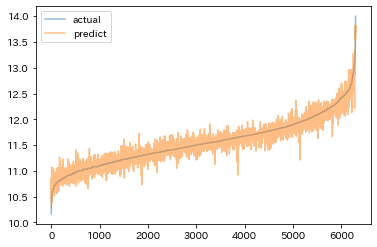

In [306]:

checktesty=valid_y.sort_values()
checktestX=valid_X.ix[list(checktesty.index)]
checktesty=checktesty.reset_index(drop=True)#これと

checkpred=pd.DataFrame(rg.predict(checktestX))#これ
# checktesty.plot()
# checkpred.plot()
check=pd.concat([checktesty,checkpred], axis=1)
check.columns=["actual","predict"]
# checktesty
check.plot(alpha=0.5)

In [315]:
predcheck=pd.concat([valid_X,(rg.predict(valid_X)-valid_y)],axis=1)
misslist=list(predcheck[abs(predcheck.value)>0.5].index)
print(np.exp(rg.predict(valid_X.ix[misslist])))
print(np.exp(train.value.ix[misslist]))
df.ix[list(predcheck[abs(predcheck.value)>0.5].index)]

[116250.57987157 186154.47910752  45868.29710111  73933.14513058
 202286.697361    55308.68211928  57025.18276221]
23316    210000.0
19960    334800.0
4860      80000.0
24184    154000.0
25838    486000.0
29426    115000.0
12471     33000.0
Name: value, dtype: float64


,id,lat,lng,access,kitchen,bath,enviroment,period,service,architect,address,bfloor,information,direction,years,value,space,width,parking
23316,23317,35.660998,139.662428,京王井の頭線\t下北沢駅\t徒歩2分\t\t京王井の頭線\t新代田駅\t徒歩8分\t\t小田...,ガスコンロ／\tコンロ3口,専用バス／\t専用トイレ／\tバス・トイレ別,【スーパー】 39m\t【スーパー】 39m\t【スーパー】 122m\t【コンビニ】 60...,2年間,エアコン付\t公営水道／\t下水／\t都市ガス,RC（鉄筋コンクリート）,東京都世田谷区代田５丁目,2階／3階建,インターネット対応,東,40年6ヶ月,210000.0,2DK,44.4m2,駐車場\t無\t駐輪場\t無\tバイク置き場\t無
19960,19961,35.653586,139.709646,山手線\t恵比寿駅\t徒歩13分\t\t東急東横線\t渋谷駅\t徒歩13分\t\t銀座線\t...,IHコンロ\t／\tコンロ1口,バスなし／\t専用トイレ,【スーパー】 235m\t【コンビニ】 61m\t【郵便局】 127m\t【銀行】 92m\...,2年間,エアコン付\t洗濯機置場なし,RC（鉄筋コンクリート）,東京都渋谷区東２丁目,3階／7階建,NaN,NaN,38年1ヶ月,334800.0,1R,60m2,NaN
4860,4861,35.785990,139.759458,日暮里・舎人ライナー\t谷在家駅\t徒歩10分\t\t日暮里・舎人ライナー\t舎人公園駅\t...,NaN,共同バス／\t共同トイレ,【スーパー】 226m\t【スーパー】 365m\t【スーパー】 612m\t【スーパー】 ...,1年間,エアコン付\tバルコニー／\tフローリング／\t室外洗濯機置場／\t敷地内ごみ置き場,鉄骨造,東京都足立区鹿浜６丁目,3階／3階建,インターネット対応／\t光ファイバー／\tインターネット使用料無料,NaN,41年5ヶ月,80000.0,1R,17.01m2,"駐車場\t空有(2台)\t15,000円\t距離1m\t(バイク置場も有り)\t駐輪場\t空..."
24184,24185,35.596116,139.705178,都営浅草線\t馬込駅\t徒歩5分\t\t都営浅草線\t西馬込駅\t徒歩11分\t\t東急大井...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,専用バス／\t専用トイレ／\tバス・トイレ別,【スーパー】 632m\t【コンビニ】 201m\t【コンビニ】 505m\t【コンビニ】 ...,NaN,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気...,RC（鉄筋コンクリート）,東京都大田区中馬込１丁目,4階／5階建,インターネット対応／\t高速インターネット／\t光ファイバー／\tCATV／\tCSアンテナ...,南,18年1ヶ月,154000.0,1K,19.08m2,"駐車場\t近隣\t30,000円\t距離400m"
25838,25839,35.745857,139.759458,高崎線\t尾久駅\t徒歩5分\t\t山手線\t田端駅\t徒歩16分\t\t京浜東北線\t上中...,給湯,NaN,NaN,15年間,公営水道／\t都市ガス,RC（鉄筋コンクリート）,東京都荒川区西尾久４丁目,1階／10階建,NaN,南東,0年6ヶ月,486000.0,1R,132.28m2,駐車場\t無
29426,29427,35.708758,139.755625,丸ノ内線(池袋－荻窪)\t本郷三丁目駅\t徒歩6分\t\t南北線\t後楽園駅\t徒歩7分\t...,ガスコンロ／\tコンロ1口／\t給湯,専用バス／\t専用トイレ／\tシャワー,NaN,2年間,エアコン付\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,鉄骨造,東京都文京区本郷４丁目,4階／4階建,インターネット対応／\tCATV,NaN,36年9ヶ月,115000.0,1R,16m2,駐車場\t無
12471,12472,35.595675,139.708370,都営浅草線\t馬込駅\t徒歩3分,NaN,NaN,NaN,NaN,都市ガス,木造,東京都大田区中馬込２丁目,2階／2階建,NaN,NaN,54年2ヶ月,33000.0,2K,17.35m2,NaN


In [307]:
fti = rg.feature_importances_

print('Feature Importances:')
for i,feat in enumerate(valid_X.columns):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))

Feature Importances:
	access     : 0.004499
	ad         : 0.003605
	years      : 0.070096
	lat        : 0.007567
	lng        : 0.006652
	L          : 0.415183
	D          : 0.000691
	height     : 0.008651
	width      : 0.105953
	エレベーター     : 0.012196
	architect  : 0.018077
	dis        : 0.018468
	ntown      : 0.031439
	bfloor     : 0.003612
	landprice  : 0.276514
	stan0      : 0.016798


In [546]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rg, X, y)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np

import numpy as np
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [0.9547919  0.95450702 0.95484143]
Average score: 0.9547134491015674


In [547]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import optuna

class RidgeCV():
    model_cls = Ridge

    def __init__(self, n_trials=100):
        self.n_trials = n_trials

    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
        elif isinstance(X, pd.DataFrame):
            X = X.reset_index(drop=True)
            y = y.reset_index(drop=True)

        self.X = X
        self.y = y

        study = optuna.create_study(direction='maximize')
        study.optimize(self, n_trials=self.n_trials)
        self.best_trial = study.best_trial

        print()
        print("Best score:", round(self.best_trial.value, 2))
        print("Best params:", self.best_trial.params)
        print()

        self.best_model = self.model_cls(**self.best_trial.params)
        self.best_model.fit(self.X, self.y)

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X.values.reshape(1, -1))
        elif isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        return self.best_model.predict(X)

    def score(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)

        return self.best_model.score(X, y)

    def kfold_cv(self, model, splits=5):
        scores = []

        kf = KFold(n_splits=splits, shuffle=True)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            model.fit(X_train, y_train)
            scores.append(model.score(X_test, y_test))

        score = np.array(scores).mean()
        return score

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

class XGBRegressorCV(RidgeCV):
    model_cls = xgb.XGBRegressor

    def __call__(self, trial):
        booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
        alpha = trial.suggest_loguniform('alpha', 1e-8, 1.0)

        max_depth = trial.suggest_int('max_depth', 1, 9)
        eta = trial.suggest_loguniform('eta', 1e-8, 1.0)
        gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        grow_policy = trial.suggest_categorical(
            'grow_policy', ['depthwise', 'lossguide'])

        if booster == 'gbtree':
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy)
        elif booster == 'dart':
            sample_type = trial.suggest_categorical('sample_type',
                                                    ['uniform', 'weighted'])
            normalize_type = trial.suggest_categorical('normalize_type',
                                                       ['tree', 'forest'])
            rate_drop = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
            skip_drop = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy,
                                   sample_type=sample_type,
                                   normalize_type=normalize_type,
                                   rate_drop=rate_drop, skip_drop=skip_drop)

        score = self.kfold_cv(model)
        return score

xgbr = XGBRegressorCV(n_trials=20)
xgbr.fit(train_X, train_y)

[I 2019-10-23 21:29:27,872] Finished trial#0 resulted in value: 0.9612816700560544. Current best value is 0.9612816700560544 with parameters: {'booster': 'gbtree', 'alpha': 0.0020212366147052446, 'max_depth': 9, 'eta': 1.4580612734891115e-07, 'gamma': 4.37990980280852e-05, 'grow_policy': 'lossguide'}.
[I 2019-10-23 21:29:44,090] Finished trial#1 resulted in value: 0.9568252494369434. Current best value is 0.9612816700560544 with parameters: {'booster': 'gbtree', 'alpha': 0.0020212366147052446, 'max_depth': 9, 'eta': 1.4580612734891115e-07, 'gamma': 4.37990980280852e-05, 'grow_policy': 'lossguide'}.


KeyboardInterrupt: 

In [ ]:
# print("lightgbm        :"+str(np.sqrt(mean_squared_error(np.exp(test_y),np.exp(gbm.predict(test_X,num_iteration=gbm.best_iteration))))) )

In [390]:

xgbr.fit(X, y)

pred=np.exp(xgbr.predict(test))

[I 2019-10-23 13:19:35,134] Finished trial#0 resulted in value: 0.9510919942158822. Current best value is 0.9510919942158822 with parameters: {'booster': 'gbtree', 'alpha': 6.000395853084827e-07, 'max_depth': 5, 'eta': 0.0040135114429623135, 'gamma': 4.032098889250773e-06, 'grow_policy': 'lossguide'}.
[I 2019-10-23 13:19:43,149] Finished trial#1 resulted in value: 0.9467448814678214. Current best value is 0.9510919942158822 with parameters: {'booster': 'gbtree', 'alpha': 6.000395853084827e-07, 'max_depth': 5, 'eta': 0.0040135114429623135, 'gamma': 4.032098889250773e-06, 'grow_policy': 'lossguide'}.
[I 2019-10-23 13:19:54,985] Finished trial#2 resulted in value: 0.9533044943609065. Current best value is 0.9533044943609065 with parameters: {'booster': 'gbtree', 'alpha': 1.831478179916323e-07, 'max_depth': 6, 'eta': 1.3015852333372284e-06, 'gamma': 0.09646484619535824, 'grow_policy': 'lossguide'}.
[I 2019-10-23 13:21:00,011] Finished trial#3 resulted in value: 0.961298531183189. Current b


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 1.8207208429912212e-05, 'max_depth': 9, 'eta': 3.071430581972498e-08, 'gamma': 1.4009180696836153e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.333976022460132e-06, 'skip_drop': 0.001276316855438467}

[13:40:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [394]:
pred=np.exp(xgbr.predict(test))

In [395]:
sub = pd.DataFrame(pd.read_csv("test.csv")['id'])
sub["value"] = list(pred)
sub.to_csv("submission2.csv", index = False)